<a href="https://colab.research.google.com/github/eagalpern/seq_analysis/blob/main/taller_analisis_secuencias_qb_2023" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preeliminares

In [ ]:
# @title Instalar y cargar librerías
!pip install --quiet Bio
!pip install --quiet py3Dmol
!pip install --quiet logomaker
import logomaker
import numba
from numba import jit
from numba import prange as parallel_range
import pandas as pd
import numpy as np
from Bio import SeqIO
from requests import get
import os
from scipy.spatial.distance import pdist,squareform
import matplotlib.pyplot as plt
import seaborn as sns
import py3Dmol
import matplotlib


In [ ]:
# @title Parámetros y archivos

family_code='PF00062'
path=''
stname=family_code+'_uniprot_st.txt'
fastaname=family_code+'_uniprot.txt'
Ali_url='https://www.ebi.ac.uk/interpro/wwwapi//entry/pfam/'+family_code+'/?annotation=alignment:uniprot'



In [ ]:
# @title Descargar alineamiento

def download(url, file_name):
    with open(file_name, "wb") as file:
        response = get(url)
        file.write(response.content)

download(Ali_url, path+stname)

# stockholm to fasta format
with open(path+stname,'r') as inFile:
    with open(path+fastaname, "w") as output_handle:
        SeqIO.write(list(SeqIO.parse(inFile,'stockholm')), output_handle, "fasta")
os.system('rm '+path+stname)


# MAKE MSA AND UNIPROT ID (name) LIST FROM FASTA
fasta_sequences = list(SeqIO.parse(path+fastaname,'fasta'))
MSA=np.empty([len(fasta_sequences),len(fasta_sequences[0].seq)],dtype='<U1')
names=[]
for j in range(len(fasta_sequences)):
    MSA[j,:]=[i for i in fasta_sequences[j].seq]
    names.append(fasta_sequences[j].id)
name_list=[names[i].split('.')[0] for i in range(len(names))]
ini=[int(names[i].split('/')[1].split('-')[0]) for i in range(len(names))]
fin=[int(names[i].split('/')[1].split('-')[1]) for i in range(len(names))]

names_table=pd.DataFrame({'name':names,'uniprot_id':name_list, 'pos_ini':ini,'pos_fin':fin})
names_table['msa_index']=names_table.index

# Curado de los datos

1.   Explorar los datos

El alineamiento que descargamos está cargado en una variable (un array de numpy), donde
```
MSA[i,j] = aminoácido 'j' de la secuencia 'i'
```
¿Cuántos residuos tiene cada secuencia? ¿Cuántas secuencias tenemos? ¿Por qué? Aprovechen:
```
MSA.shape
```
En otra variable (un dataframe de pandas), están cargados los nombres de cada secuencia


2.   Tratamiento de gaps

Para alinear las secuencias, fueron agregados gaps ( - ) a los residuos originales. Vamos a incorporarlos como si fueran un aminoácido más, pero el alineamiento tiene demasiados. Una opción es elegir una secuencia particular como referencia y quedarnos solo con sus posiciones, eliminando otras columnas. Hacerlo usando la función dada y luego analicen con un histograma cuantos gaps tiene cada secuencia (cada fila) del alineamiento resultante. ¿Que podemos hacer?


3.  Sesgo de secuenciación y filogenético

Para hacer estadísticas con las secuencias, necesitamos limpiar la redundancia dada por estos sesgos. Utilizar la función dada y discutir que cuttoff usar.

In [ ]:
# @title Eliminar columnas del alineamiento según secuencia de referencia

def remove_gaps_target_seq(MSA,names_table,pdb_seq):
  ix=names_table.loc[names_table.uniprot_id==pdb_seq].index[0]
  col_nogap=np.where(MSA[ix,:]!='-')[0]
  return MSA[:,col_nogap]

# secuencia de referencia
pdb_seq='P00698'




In [ ]:
# @title Cálculo de pesos


# pasar el alineamiento de letras a números según este diccionario
AA_dict_full={'X':0,'Y':0,'Z':0,'B':0, '-':0,'A':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'K':9,'L':10,'M':11,'N':12
        ,'P':13,'Q':14,'R':15,'S':16,'T':17,'V':18,'W':19,'Y':20}
msa=np.array([[AA_dict_full[aa.upper()] for aa in MSA_nogap[i,:]] for i in range(MSA_nogap.shape[0])])


def get_eff(msa,eff_cutoff=0.8):
  '''compute effective weight for each sequence'''
  ncol = msa.shape[1]

  # pairwise identity
  msa_sm = 1.0 - squareform(pdist(msa,"hamming"))

  # weight for each sequence
  msa_w = (msa_sm >= eff_cutoff).astype(float)
  msa_w = 1/np.sum(msa_w,-1)
  return msa_w






# Frecuencia de aminoácidos por sitio

1.   Calcular usando la función dada las frecuencias aminoacídicas por posición, usando los pesos obtenidos anteriormente. Hacer un heatmap de la matriz obtenida usando [sns.heatmap()](https://seaborn.pydata.org/generated/seaborn.heatmap.html) e interpretar.


2.   ¿Cuál es la secuencia consenso de este alineamiento? *Ayuda: usar np.argmax()*


In [ ]:
#  @title Cálculo de frecuencias por sitio

# fij quizás en otra ocasión puede servirles...
Naa=21
def freq(ali,Naa,w):
    npos=ali.shape[1]
    #fij=np.zeros((npos,npos,Naa,Naa))
    fi=np.zeros((npos,Naa))
    for i in range(npos):
        fi[i,:]=np.histogram(ali[:,i],bins=np.arange(-0.5,Naa+0.5),weights=w)[0]
    #    for j in range(npos):
            #if j!=i:
    #         fij[i,j,:,:]=np.histogram2d(ali[:,i],ali[:,j],bins=np.arange(-0.5,Naa+0.5),weights=w)[0]
    fi=fi/sum(w)
    #fij=fij/sum(w)
    #return fij,fi
    return fi

# Información por sitio y logo de secuencia

En [este paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC332411/pdf/nar00204-0153.pdf) (DOI: 10.1093/nar/18.20.6097) se propone una definición para la información por sitio de un alineamiento de secuencias y una visualización gráfica, el logo.


1.   Implementar una función para calcular la información por sitio en bits a partir de la matriz de frecuencias ya calculada anteriormente. Graficar información por sitio en función de la posición.

2.   Armar un alieamiento del mismo número de secuencias que el original, pero en el cual cada posición tenga un aminoacido al azar (*Ayuda: usar np.random.choice()*) y calcular la información por sitio en este caso.

3.   Proyectar sobre la estructura obtenida del pdb la información por sitio, utilizando la función dada. Discutir el resultado.

3.   *Logo de secuencias*. Utilizando el ejemplo dado, calcular el logo de secuencias para nuestro alineamiento, aprovechando la matriz de frecuencias ya calculadas. En este caso, descartar la frecuencia de los gaps.

In [ ]:
# @title Proyeccion de una señal sobre un pdb

def view_3d_exon_hist(ali_seq,colors,pdb):

    view = py3Dmol.view(query='pdb:'+pdb,width=800, height=600)
    view.setBackgroundColor('white')

    view.setStyle({'cartoon':{'color':'white'}})
    view.setStyle({'chain':'B'},{'opacity':0 })
    view.setStyle({'chain':'C'},{'opacity':0 })
    view.setStyle({'chain':'D'},{'opacity':0 })
    view.setStyle({'chain':'E'},{'opacity':0 })
    view.setStyle({'chain':'F'},{'opacity':0 })
    view.setStyle({'chain':'G'},{'opacity':0 })
    view.setStyle({'chain':'O'},{'opacity':0 })


    #change residue color
    for i,res in enumerate(ali_seq):
        if res>0: #gaps are res=-1 and we dont want them
            view.addStyle({'chain':'A','resi':[str(res)]},{'cartoon':{'color':colors[i]}})
        #view.addStyle({'chain':'A','resi':[str(alinum.no[e_])]},{'cartoon':{'color':'white'}})
    view.zoomTo(viewer=(0,0))
    return view

    def map_signal_to_colors(signal,vmin,vmax,cmap='cool'):
      cmap=matplotlib.cm.get_cmap(cmap)
      norm = matplotlib.colors.Normalize(vmin,vmax)
      rgba_values = cmap(norm(signal))
      colors=[]
      for rgba in rgba_values:
          colors.append(matplotlib.colors.rgb2hex(rgba))
      return colors

pdb='2lyz'
ali_seq=np.arange(1,128)
colors=map_signal_to_colors(info,0,np.log2(Naa),cmap='viridis')
view_3d_exon_hist(ali_seq,colors,pdb)

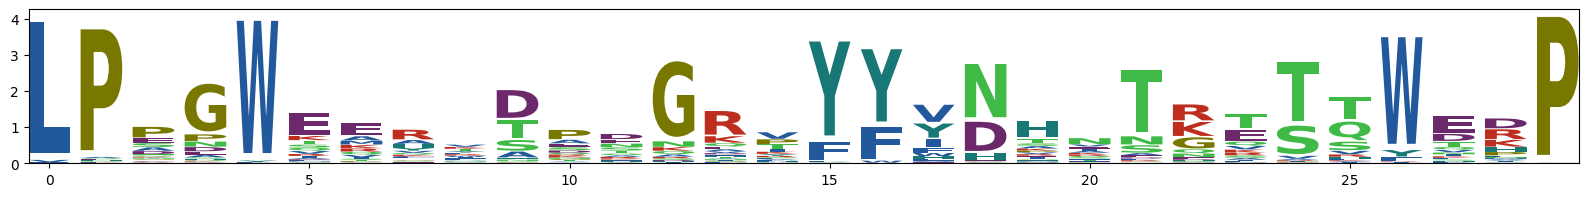

In [ ]:
# @title Logo de secuencias (ejemplo de la librería)

# load ww information matrix
ww_df = logomaker.get_example_matrix('ww_information_matrix',
                                     print_description=False)
# create Logo object
fig,ax=plt.subplots(figsize=(15,2))
ww_logo = logomaker.Logo(ww_df,
                         color_scheme='NajafabadiEtAl2017',
                         vpad=.1,
                         width=.8, ax=ax)

# Modelo de sitios independientes

En [este review](https://sci-hub.se/10.1088/1361-6633/aa9965) (DOI 10.1088/1361-6633/aa9965) se presentan modelos donde a partir de la variabilidad dentro de un alineamiento se infiere la probabilidad de aparición de cada secuencia. El más sencillo de estos evolutivos es el de sitios independientes.


1.   Con la función dada, calcular el campo local h, aprovechando la matriz de frecuencias por sitios ya obtenida. Graficar la matriz h como un heatmap y analizar el resultado.

2.   Calcular una matriz que tenga en cada una de sus filas la energía que aporta cada sitio de una secuencia del alineamiento a la energía. Repetir el procedimiento con el alineamiento random. ¿Qué diferencia hay?

3.   Calcular la energía total de cada secuencia y graficar la distribución para todo el alineamiento. Utilizando el mismo campo, calcular la energía total de las secuencias del alineamiento random. Comparar las distribuciones. ¿Qué mide esta energía? *Ayuda: utilizar sns.kdeplot() y recordar los pesos para el alineamiento natural*


4.   Proyectar la energía promedio por sitio sobre la estructura tridimensional. Graficar la información total por sitio vs la energía promedio por sitio. ¿Tienen algo que ver estas dos medidas? ¿Por qué?

5.   Calcular el costo energético (según este campo) para una mutación puntual. ¿Se puede calcular cual sería la mutación de mayor costo energético para un sitio?

6.   ¿Como cambia este modelo si relajamos la hipótesis de sitios independientes? ¿Tendría sentido? *Ayuda: volver al review*




In [ ]:
# @title Calculo del campo local, modelo de sitios independientes

def campo_h(f,corr=1e-4):
    h=-np.log(f+corr)
    return h-np.tile(np.nansum(h,axis=1)/21,(21,1)).T


# Ayudas y respuestas (no abrir sin intentar primero...)

0.628785046728972
(3364, 127)


array(['K', 'T', 'Y', 'K', 'Y', 'C', 'E', 'L', 'T', 'H', 'E', 'L', 'Y',
       'R', 'K', 'H', 'H', '-', '-', 'I', 'P', 'L', 'E', 'Q', 'I', 'P',
       'I', 'W', 'I', 'C', 'I', 'V', 'Q', 'H', 'E', 'S', 'D', 'F', 'N',
       'T', 'A', 'A', 'V', 'A', 'R', 'V', '-', 'N', 'G', 'S', 'T', 'N',
       'H', 'G', 'I', 'F', 'Q', 'I', 'S', 'D', 'L', 'Y', 'W', 'C', 'S',
       'H', 'D', 'R', '-', '-', 'N', 'G', 'G', 'K', 'A', 'C', 'N', 'I',
       'S', 'C', 'D', 'D', 'L', 'L', 'D', 'S', 'D', 'I', 'S', 'D', 'D',
       'V', 'R', 'C', 'V', 'K', 'T', 'I', 'Y', 'e', 'E', 'H', 'D', 'G',
       'F', 'T', 'A', 'W', 'V', 'A', 'Y', 'K', 'P', 'H', 'C', 'R', 'n',
       'K', 'T', 'L', 'E', 'D', 'I', '-', 'N', 'Q', 'C'], dtype='<U1')

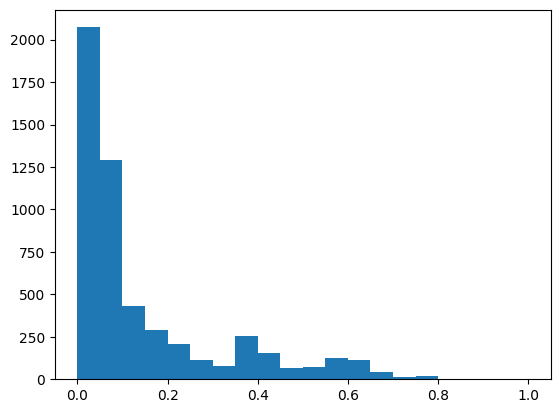

In [ ]:
# @title Tratamiento de gaps

MSA_nogapcol=remove_gaps_target_seq(MSA,names_table,pdb_seq)

plt.hist((MSA_nogapcol=='-').sum(axis=1)/MSA_nogapcol.shape[1],bins=np.linspace(0,1,21))

row_nogap= np.where((MSA_nogapcol=='-').sum(axis=1)/MSA_nogapcol.shape[1]<0.1)[0]
print(len(row_nogap)/MSA_nogapcol.shape[0])
MSA_nogap=MSA_nogapcol[row_nogap,:]
print(MSA_nogap.shape)
MSA_nogap[0,:]


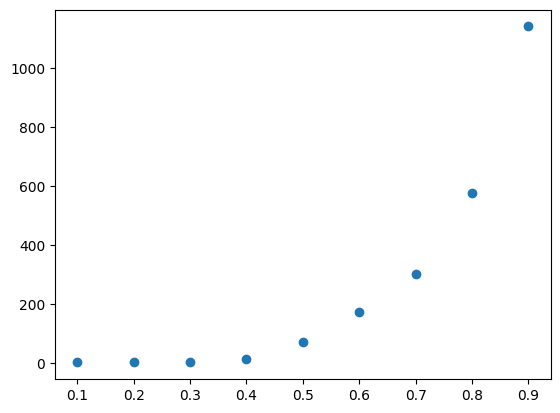

In [ ]:
# @title pesos: ¿que cutoff utilizar?

cutoffs=np.linspace(0.1,0.9,9)
eff_seq=[]
for i,cutoff in enumerate(cutoffs):
  msa_wc=get_eff(msa,eff_cutoff=cutoff)
  eff_seq.append(sum(msa_wc))
plt.scatter(cutoffs,eff_seq)

<ipython-input-209-4b6a30e7a1b4>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=matplotlib.cm.get_cmap(cmap)


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

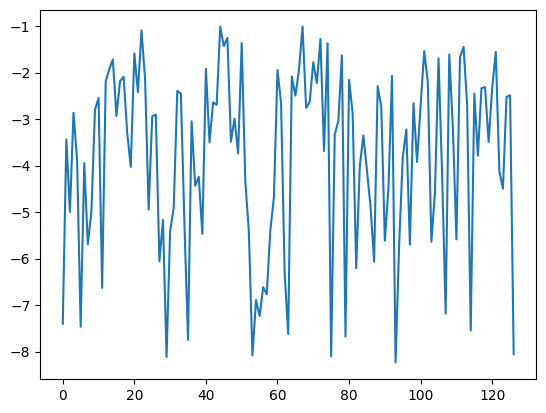

In [ ]:
# @title Energía media por sitio

average_energy=np.average(energy_site_matrix,weights=msa_w,axis=0)

plt.plot(average_energy)
plt.scatter(info,average_energy)

colors=map_signal_to_colors(average_energy,
                            min(average_energy),
                            max(average_energy),cmap='viridis_r')
view_3d_exon_hist(ali_seq,colors,pdb)

In [ ]:
# @title Frecuencias por sitio y secuencia consenso
fi = freq(msa,Naa,msa_w)
AA_dict_={'-':0,'A':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'K':9,'L':10,'M':11,'N':12
        ,'P':13,'Q':14,'R':15,'S':16,'T':17,'V':18,'W':19,'Y':20}
AA_dict_inv = {v: k for k, v in AA_dict_.items()}
fig,ax=plt.subplots(figsize=(14,3.5))
sns.heatmap(fi.T,ax=ax,cmap='viridis')
ax.set_yticks(np.arange(0.5,21.5),AA_dict_.keys(),fontsize=8);


# secuencia consenso
np.array([AA_dict_inv[x] for x in np.argmax(fi,axis=1)])

Text(0, 0.5, 'Información [bits]')

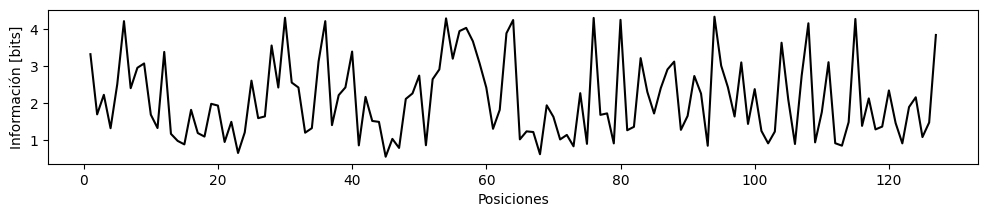

In [ ]:
# @title Información por sitio
info=np.log2(Naa)-np.nansum(-fi*np.log2(fi),axis=1)


fig,ax=plt.subplots(figsize=(12,2))
ax.plot(ali_seq,info,c='k')
ax.set_xlabel('Posiciones')
ax.set_ylabel('Información [bits]')

In [ ]:
# @title alineamiento random

msa_random=np.array([np.random.choice(range(Naa), size=msa.shape[1],
                  replace=True, p=None) for j in range(msa.shape[0])])

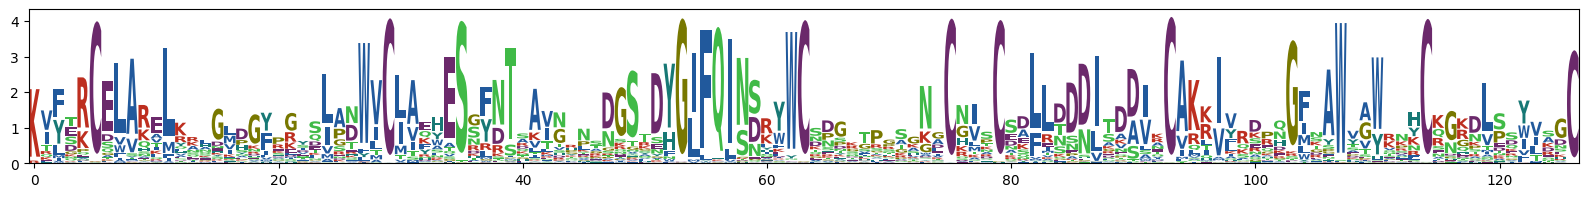

In [ ]:
# @title Logo de secuencias

prob_matrix_df=pd.DataFrame(fi[:,1:]*np.tile(info,(20,1)).T)
prob_matrix_df.columns=[x for x in AA_dict_.keys()][1:]

fig,ax=plt.subplots(figsize=(20,2))
logomaker.Logo(prob_matrix_df,
                         color_scheme='NajafabadiEtAl2017',
                         vpad=.1,
                         width=.95,ax=ax)

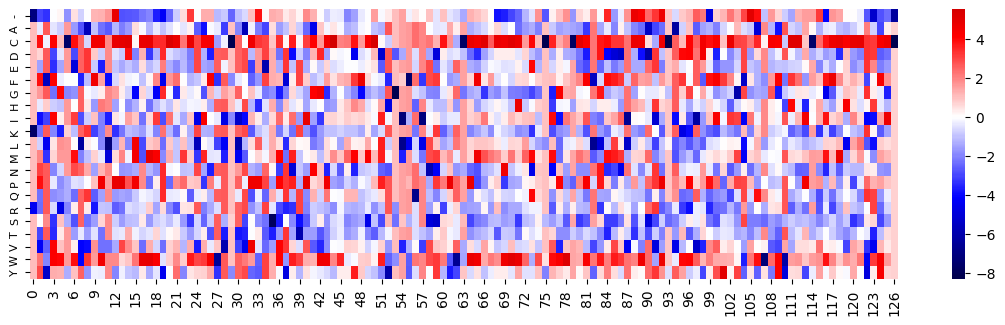

In [ ]:
# @title Campo local, modelo de sitios independientes

hi=campo_h(fi)

fig,ax=plt.subplots(figsize=(14,3.5))
sns.heatmap(hi.T,ax=ax,cmap='seismic',center=0)
ax.set_yticks(np.arange(0.5,21.5),AA_dict_.keys(),fontsize=8);


In [ ]:
# @title Contribución por sitio a la energía de cada secuencia


def energy_sm(h_i,msa):
  return np.array([[hi[i, aa_i] for i,aa_i in enumerate(msa[j,:])] for j in range(msa.shape[0])])

energy_site_matrix=energy_sm(hi,msa)
energy_site_matrix_random=energy_sm(hi,msa_random)

sns.heatmap(energy_site_matrix,cmap='seismic',center=0)

sns.heatmap(energy_site_matrix_random,cmap='seismic',center=0)

In [ ]:
# @title Distribución de la energía total de cada secuencia

total_energy=energy_site_matrix.sum(axis=1)
df=pd.DataFrame({'energy':total_energy,'w':msa_w})
total_energy_random=np.nansum(energy_site_matrix_random,axis=1)

sns.kdeplot(data=df, x='energy',weights='w')
sns.kdeplot(total_energy_random)


# Extras

In [ ]:
# @title Función alternativa para calcular pesos

@jit(nopython=True, parallel=True)
def compute_sequences_weight(alignment_data=None, seqid=None):
    """Computes weight of sequences. The weights are calculated by lumping
    together sequences whose identity is greater that a particular threshold.
    For example, if there are m similar sequences, each of them will be assigned
    a weight of 1/m. Note that the effective number of sequences is the sum of
    these weights.

    Parameters
    ----------
        alignmnet_data : np.array()
            Numpy 2d array of the alignment data, after the alignment is put in
            integer representation
        seqid : float
            Value at which beyond this sequences are considered similar. Typical
            values could be 0.7, 0.8, 0.9 and so on

    Returns
    -------
        seqs_weight : np.array()
            A 1d numpy array containing computed weights. This array has a size
            of the number of sequences in the alignment data.
    """
    alignment_shape = alignment_data.shape
    num_seqs = alignment_shape[0]
    seqs_len = alignment_shape[1]
    seqs_weight = np.zeros((num_seqs,), dtype=np.float64)
    #count similar sequences
    for i in parallel_range(num_seqs):
        seq_i = alignment_data[i]
        for j in range(num_seqs):
            seq_j = alignment_data[j]
            iid = np.sum(seq_i==seq_j)
            if np.float64(iid)/np.float64(seqs_len) > seqid:
                seqs_weight[i] += 1
    #compute the weight of each sfreq(ali,npos,Naa,w)equence in the alignment
    for i in range(num_seqs): seqs_weight[i] = 1.0/float(seqs_weight[i])
    return seqs_weight


#seqs_weight=compute_sequences_weight(alignment_data=MSA_nogap, seqid=0.8)